<a href="https://colab.research.google.com/github/SBGlab/GoldenStandardDataset/blob/main/paper_datasets_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Golden Standard Dataset folder from GitHub

!git clone https://github.com/SBGlab/GoldenStandardDataset.git

Cloning into 'GoldenStandardDataset'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 208 (delta 5), reused 2 (delta 2), pack-reused 196
Receiving objects: 100% (208/208), 8.30 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [2]:
#@title Import modules and functions

import sys
sys.path.append('/content/GoldenStandardDataset')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout
from scipy import stats, integrate
import csv
import os
from google.colab import files as FILES
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

from algorithm_iteration import *
from functions import *

print('Modules and functions imported successfully')

Modules and functions imported successfully


In [15]:
#@title Dataset selection

#Acessing the folders and selecting the dataset to analyse
folders = []
path = '/content/GoldenStandardDataset'
obj = os.scandir(path)
for entry in obj:
    if entry.is_dir() and '.git' not in entry.name and '__pycache__' not in entry.name and 'Custom_data_example' not in entry.name:
        folders.append(entry.name)

folders = sorted(folders)
style = {'description_width': 'initial'} #for widgets layout
#dropdown menu to select dataset
dataset_folder = widgets.RadioButtons(
    options=folders,
    description='Select dataset to analyze: ',
    disabled=False,
    style=style,
    layout=Layout(width='90%'))
display(dataset_folder)

RadioButtons(description='Select dataset to analyze: ', layout=Layout(width='90%'), options=('KT_B0034_BCD2_BC…

In [16]:
#@title Import selected dataset

#Creating new path with the selected folder and getting the names of the data files
new_path = path + '/' + dataset_folder.value
files = os.listdir(new_path)
datasets_dict = {}
for file in files:
    if 'SAMPLES' in file:
        samples_file = file
    else:
        f = file.replace('.','_')
        f = f.split('_')
        dataset_name = f[-2]
        datasets_dict.update({dataset_name : file})

#Assigning new paths to each data file and assigning
#the corresponding data structure for further analysis
DF_def = {}
dfs_raw_names = list(datasets_dict)

for dataset in datasets_dict:
    dataset_path = new_path + '/' + datasets_dict[dataset]
    DF_def[dataset] = pd.read_csv(dataset_path, index_col=0)

samples_path = new_path + '/' + samples_file
f = open(samples_path, 'r')
lines = f.readlines()
f.close()
samples_input_str = str(lines)

#defining time and bouts
time = np.array(DF_def[dataset].index)
bouts = time[1]-time[0]

print('INPUT SUMMARY:')
print('--------------\n')
print('File with %d datasets: ' %len(dfs_raw_names), dfs_raw_names)
print('\nbouts = %.2f (h\u207B\u00B9)' %bouts)

#Creating the sample-well strcuture
samples = text_to_sample(samples_input_str)

sample_names = []
samples_def = {}
blanks_def = {}
wells_def = []

for line in samples:
    wells = sample_to_wells(line)
    wells_temp =[]
    for i, well in enumerate(wells):
        if i == 0:
            sample_name = well
            if sample_name == 'blank':
                pass
            else:
                sample_names.append(sample_name)
        else:
            wells_temp.append(well)
            wells_def.append(well)
    if sample_name == 'blank':
        blanks_def.update({sample_name : wells_temp})
    else:
        samples_def.update({sample_name : wells_temp})

print('\nSamples:\n')
print(*samples_def.items(), sep='\n')
print('\nBlanks:\n')
print(*blanks_def.items(), sep='\n')

recalc = 1

INPUT SUMMARY:
--------------

File with 2 datasets:  ['RFP', 'OD']

bouts = 0.50 (h⁻¹)

Samples:

('B0034', ['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
('BCD2', ['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])
('BCD12', ['F7', 'F8', 'F9', 'F10', 'F11', 'F12'])
('RBSDummy', ['G7', 'G8', 'G9', 'G10', 'G11', 'G12'])

Blanks:

('blank', ['H1', 'H2', 'H3'])


IntProgress(value=0, bar_style='success', description='Plotting plate datasets... ', max=1166, style=ProgressS…

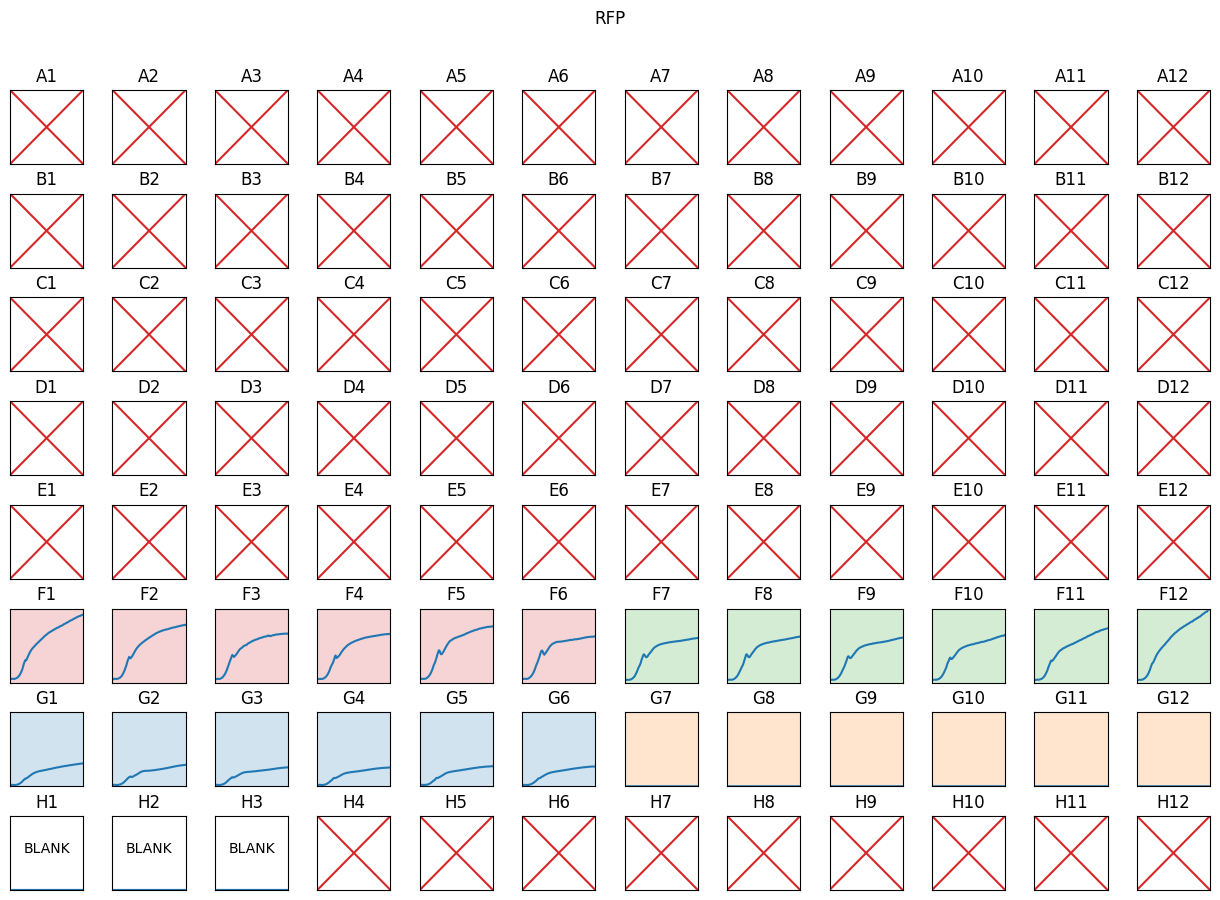

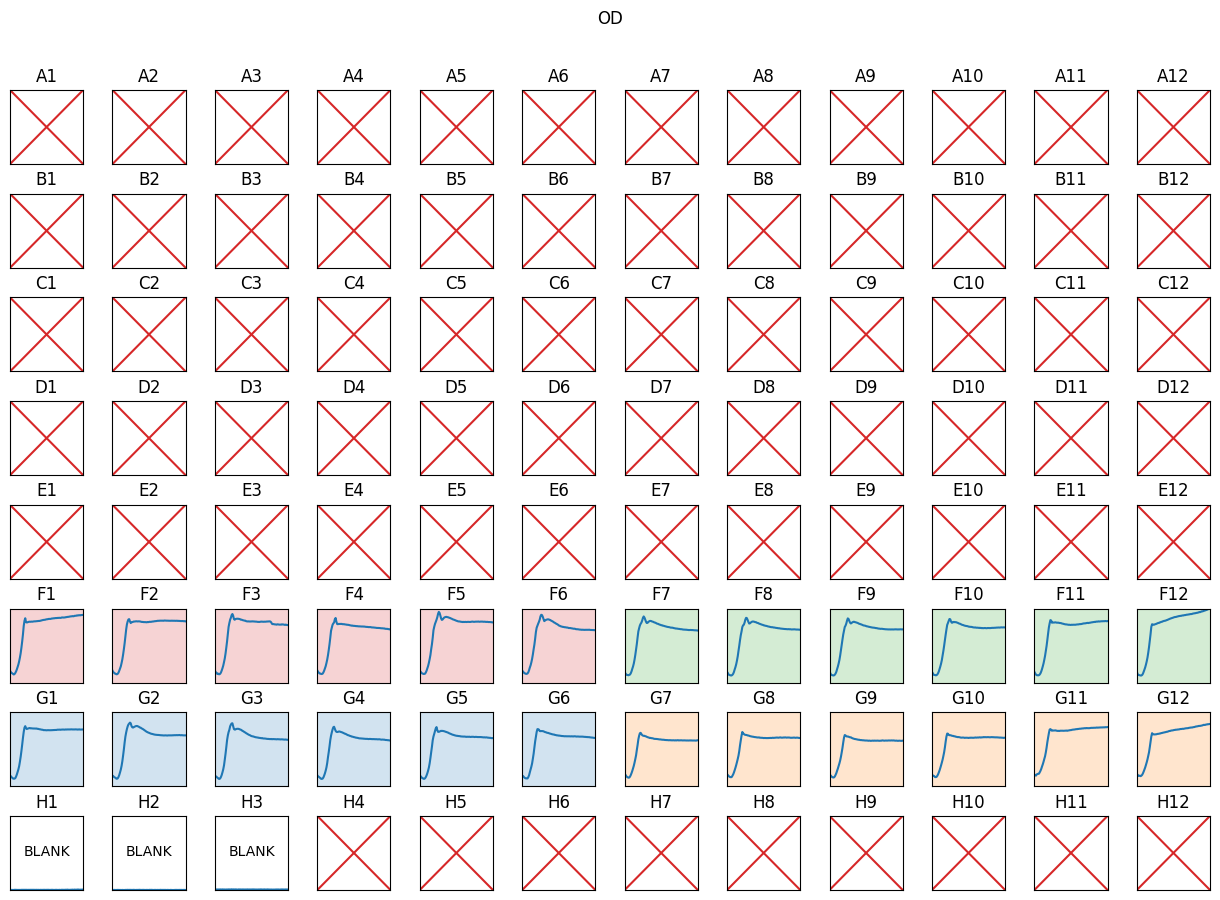

In [17]:
#@title Plate visualization

max_count = 583 * len(DF_def) #parameter for progress bar
wells_out = spot_removed_wells(DF_def) #check wells outside of analysis
#progress bar widgets parameters
f = widgets.IntProgress(min=0, max=max_count,
                description='Plotting plate datasets... ',
                bar_style='success',
                style=style) # instantiate the bar
display(f) # display the bar
#cross function
x = np.linspace(0,1)
y = x
y2 = -x+1
#create plots
for dataframe in DF_def:
    u = max(DF_def[dataframe].max()) #get y max
    f.value += 1
    d = min(DF_def[dataframe].min()) #get y min
    f.value += 1
    fig, axs = plt.subplots(8, 12, figsize=(15,10)) #create 96 plots in 8x12 array
    f.value += 1
    fig.suptitle(dataframe)
    f.value += 1
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    f.value += 1
    #create each plot
    for i, ax in zip(wells_in_plate, axs.ravel()):
        f.value += 1
        #if well is outside analysis plot red cross
        if i in wells_out:
            ax.plot(x, y, c='tab:red')
            ax.plot(x, y2, c='tab:red')
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)
        #else plot actual data
        else:
            ax.plot(time, DF_def[dataframe][i], label=i)
            ax.set_ylim(d, u)
            ax.set_xlim(0,time[-1])
            for sample, c in zip(samples_def, colors):
              if i in samples_def[sample]:
                ax.patch.set_facecolor(c)
                ax.patch.set_alpha(0.2)
            #display blank as text
            if i in blanks_def['blank']:
                ax.text(time[-1]/2, u/2, 'BLANK', ha='center')
        f.value += 1
        ax.set_title(i)
        f.value += 1
        ax.set_xticks([])
        f.value += 1
        ax.set_yticks([])
        f.value += 2
    plt.show()
    f.value += 1
    print('')
    f.value += 1# signal to increment the progress bar

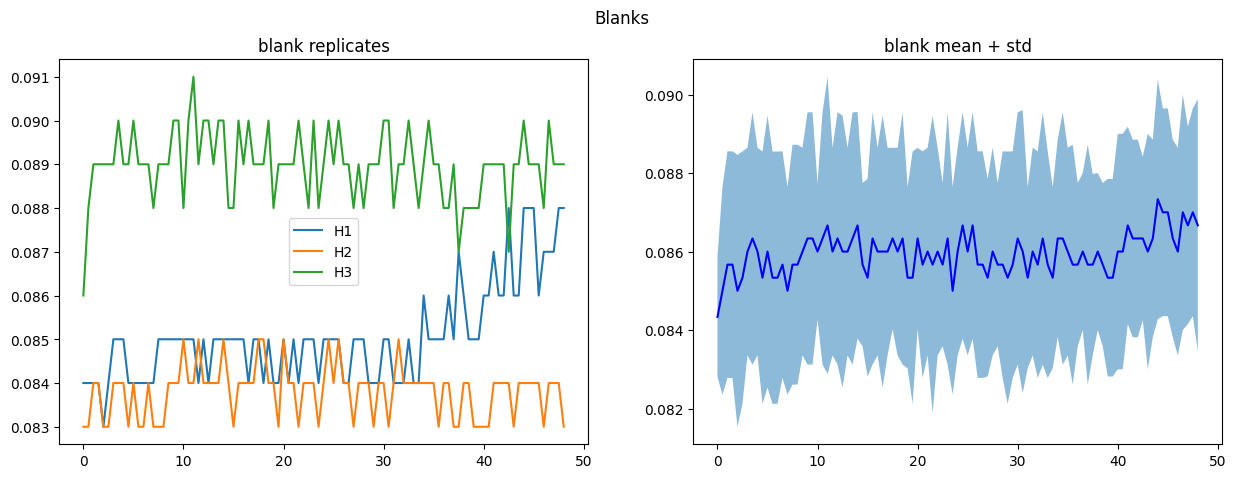

In [18]:
#@title Blank plots

growth = 'OD'

blk_means = pd.DataFrame()
blk_stds = pd.DataFrame()

df_growth = DF_def[growth]
wells = blanks_def['blank']
blk_means = pd.concat([blk_means, df_growth[wells].mean(axis=1)], axis=1)
blk_stds = pd.concat([blk_stds, df_growth[wells].std(axis=1)], axis=1)
blk_means.columns = ['blank']
blk_stds.columns = ['blank']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Blanks')
ax2.plot(time, blk_means['blank'], 'b-')
ax2.fill_between(time, blk_means['blank'].astype(float)+blk_stds['blank'].astype(float), blk_means['blank'].astype(float)-blk_stds['blank'].astype(float), alpha=0.5)
ax2.set_title(('blank mean + std'))

for i in range(len(wells)):
    ax1.plot(time, df_growth[wells[i]], label=wells[i])
ax1.set_title('blank replicates')
ax1.legend()
plt.show()

In [19]:
#@title Blank subtraction

#Run only once if DF_def is not recalculated. You might be subtracting the BLK several times
if recalc == 1:
    pass
else:
    raise Exception('Blank already subtracted, if you want to run this operation again data must be reloaded first')
#subtract BLK means to growth dataset and remove them from DF_def
DF_noblk = DF_def['OD'].sub(list(blk_means['blank']), axis=0).drop(blanks_def['blank'], axis=1)
DF_def.update({'OD': DF_noblk})

#create growth rate dataset
DF_gr = pd.DataFrame()
DF_gr_prev = np.log(DF_noblk.astype(float)) #convert OD into ln OD
for c in DF_gr_prev:
    grad = np.gradient(DF_gr_prev[c], bouts) #gradient of ln OD
    DF_gr[c] = grad #store gradient of each well in a column with the well as header
DF_gr.index = time
DF_def.update({'Growth rate' : DF_gr})

#create dynamic activity dataset
for name in dfs_raw_names:
    if name == 'OD': #this is done to every fluorescence dataset (not for growth)
        pass
    else:
        DF_PAdyn  = pd.DataFrame()
        DF_PAdyn_prev  = pd.DataFrame()
        DF_fp = DF_def[name]
        for c in DF_fp:
            grad = np.gradient(DF_fp[c], bouts) #gradient of fluorescence
            DF_PAdyn_prev[c] = grad #store gradient of each well in a column with the well as header

        DF_PAdyn_prev.index = time

        DF_PAdyn = DF_PAdyn_prev.div(DF_def['OD']) #divide growth values to gradient of fluorescence
        s = str('Dynamic Activity ' + name)
        DF_def.update({s : DF_PAdyn})
recalc = 0

print('Blank subtracted successfully')

Blank subtracted successfully


Crop data until (h):15


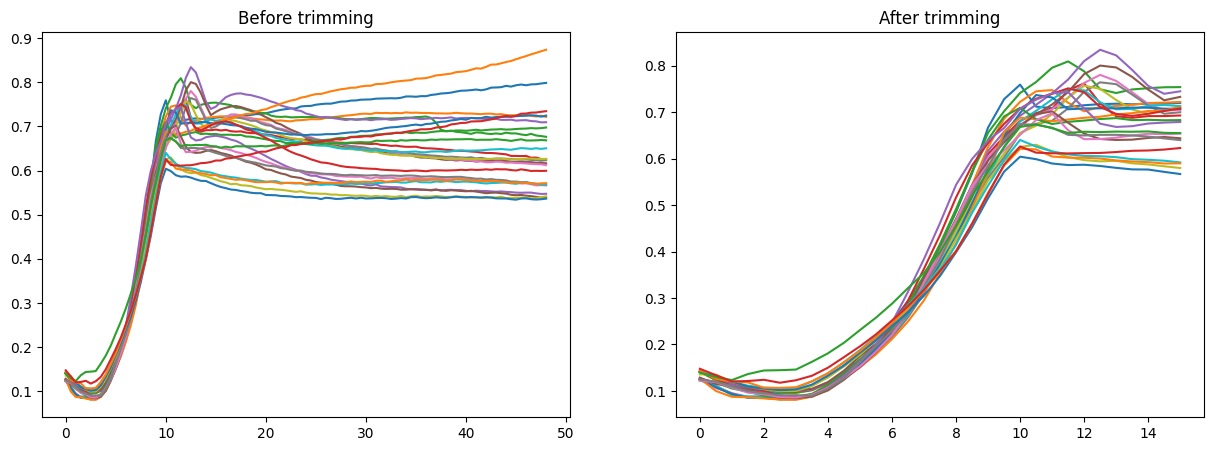

In [20]:
#@title Trim data

#Trim first to compute outliers and algorithm of the trimmed data
#(we used 15h for KT and 30h for W)
print('WARNING: This action is irreversible, deleted values cannot be recovered unless restart')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(DF_def['OD'])
ax1.set_title('Before trimming')

trim = float(input('Crop data until (h):'))
for key in DF_def.keys():
    DF_def[key] = DF_def[key][:trim]
for i, value in enumerate(time):
    if value == trim:
        time = time[:i+1]

ax2.plot(DF_def['OD'])
ax2.set_title('After trimming')
plt.show()

Number of std above the z-scores mean for outlier cutoff: 3

 Outliers found: ['G11']


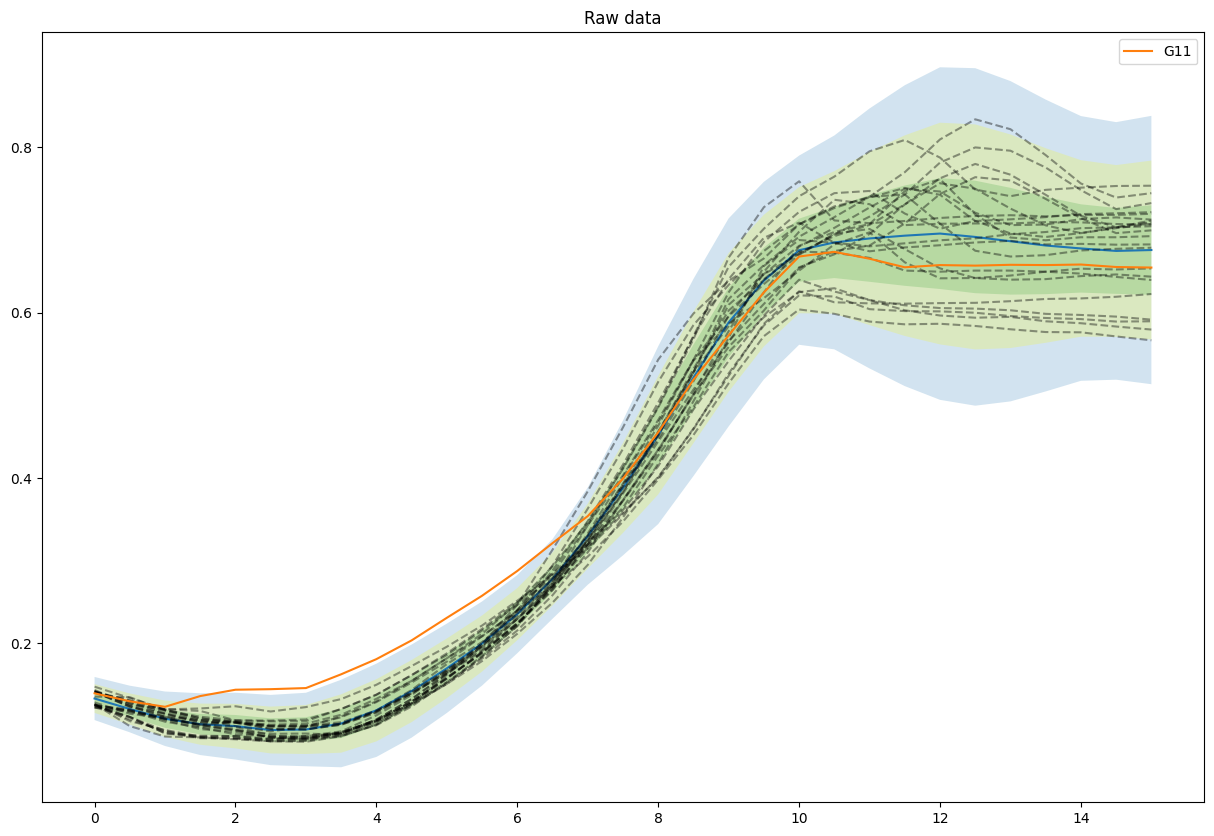

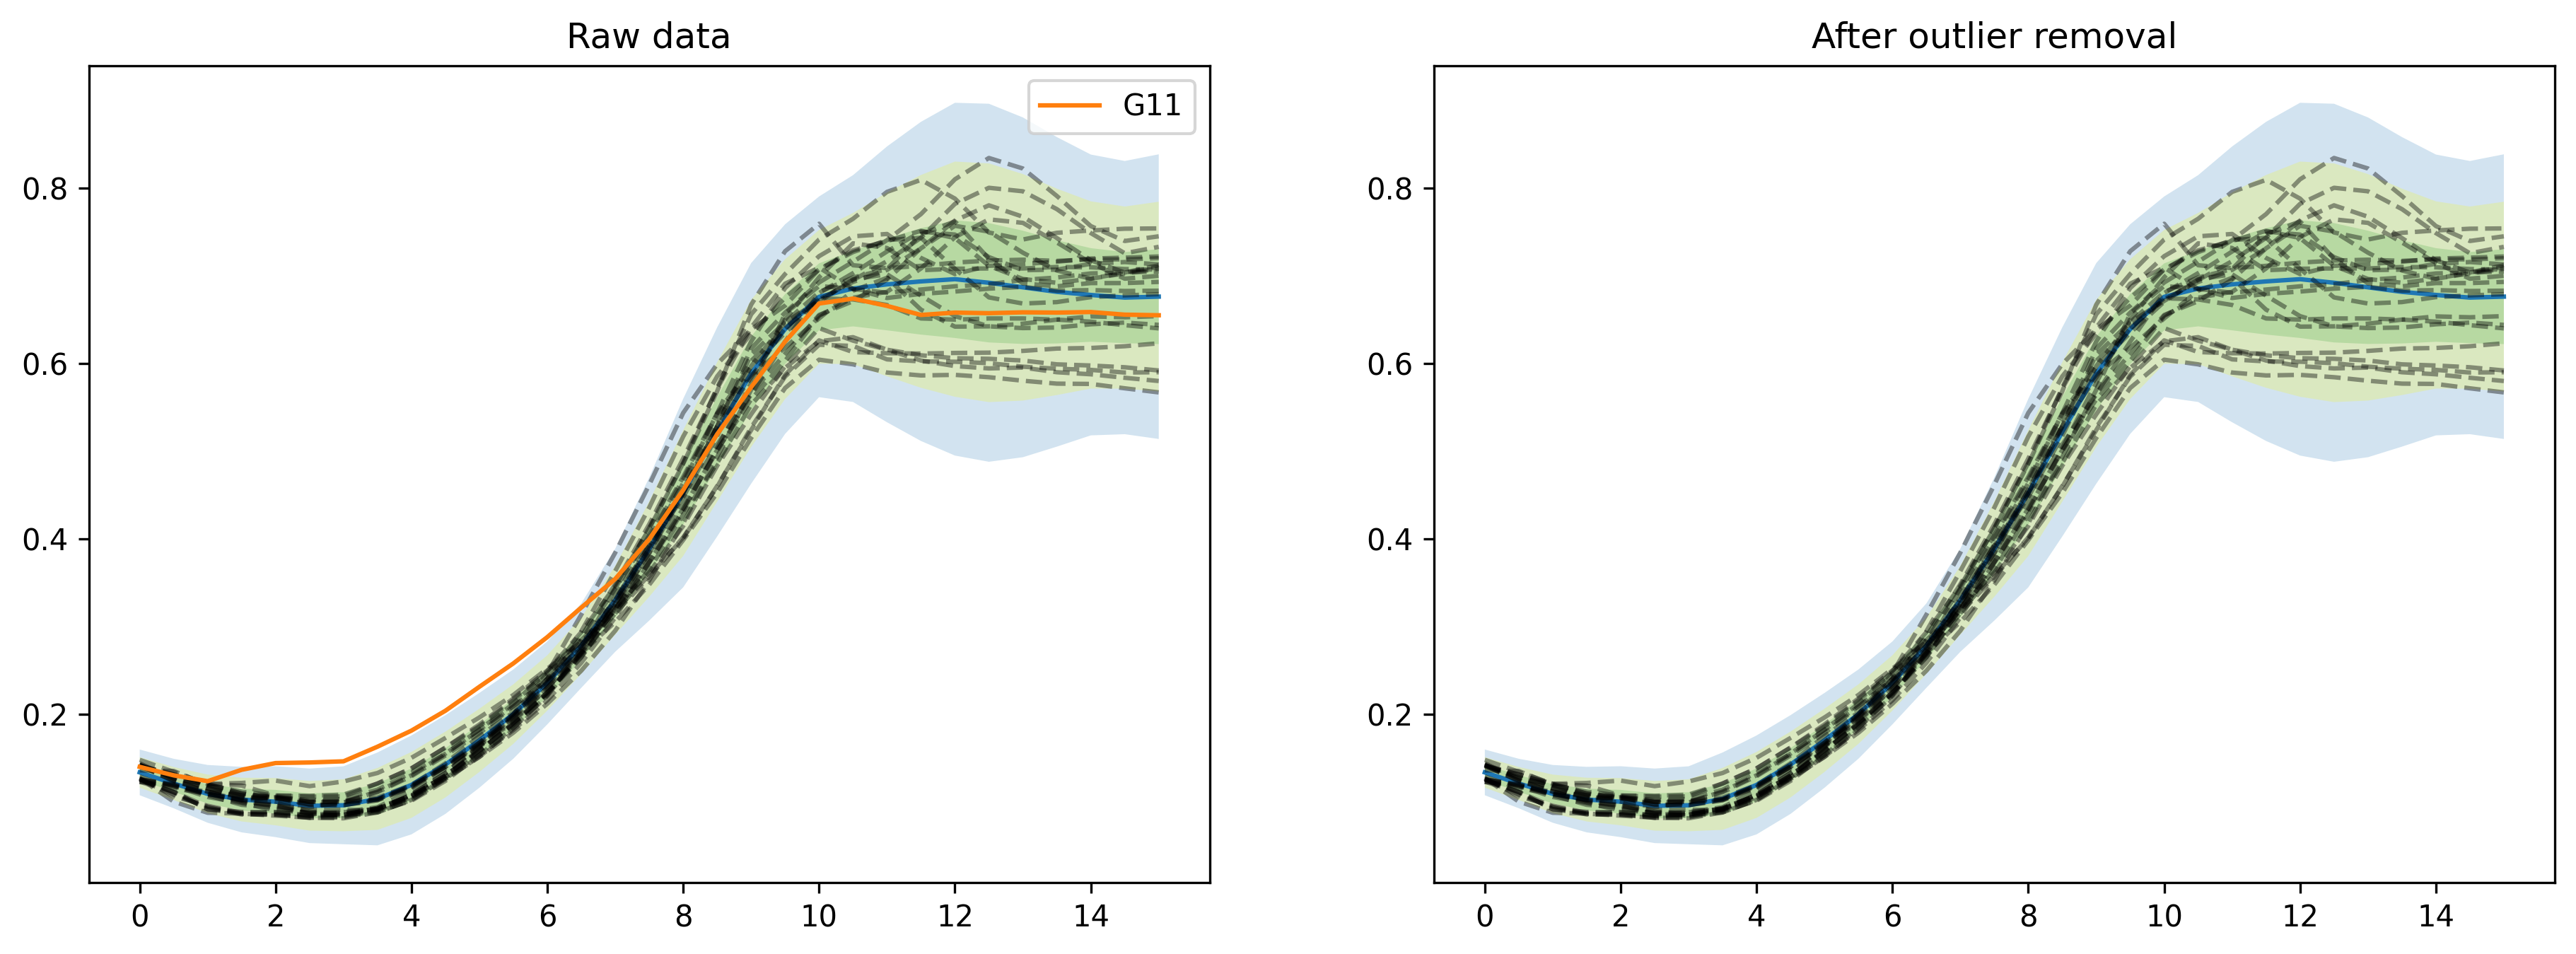

In [21]:
#@title Outliers detection

#Compute z-scores for every individual sample in the data (takes into account trimming)
#and compare it with the mean of the whole plate. Stablish a cut-off level based on
#a number of std above or below the mean and eliminate this well data from the dataframes
#(we used a value of 3 stds above and below the mean to indentify outliers as Zeevi et al.)

DF_def_inverted = DF_def['OD'].transpose()

zgen = []
for timepoint in DF_def_inverted.columns:
    data = DF_def_inverted[timepoint]
    z = []
    for i in range(len(data)):
        target = data[i]
        data_copy = list(data).copy()
        data_copy.remove(target)
        sample_mean = np.mean(data_copy)
        sample_std = np.std(data_copy)
        #z_score = (target - sample_mean)/sample_std #shouldn't this be an abs()?
        z_score = (abs(target - sample_mean))/sample_std
        z.append(z_score)
    zgen.append(z)

zscores_dict = {}
for idx, sample in enumerate(DF_def_inverted.index):
    temp_zscore = []
    for timepoint in zgen:
        sample_zscore = timepoint[idx]
        temp_zscore.append(sample_zscore)
    zscores_dict.update({sample : sum(temp_zscore)})

zscore_mean = np.mean(list(zscores_dict.values()))
zscore_std = np.std(list(zscores_dict.values()))

std_input_val = int(input('Number of std above the z-scores mean for outlier cutoff: '))
t = zscore_mean + std_input_val * zscore_std
threshold = []
for well in zscores_dict:
    if zscores_dict[well] < t:
        threshold.append(well)

outliers = []
for i in list(zscores_dict):
    if i not in threshold:
        outliers.append(i)

if len(outliers) == 0:
    print('\nNo outliers found for that cutoff level')
else:
    print('\n Outliers found: %s' %outliers)

all_mean = DF_def['OD'].mean(axis=1)
all_std = DF_def['OD'].std(axis=1)

fig,ax = plt.subplots(figsize=(15,10))

ax.plot(time, all_mean)
ax.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:blue', alpha=0.2)
ax.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.2)
ax.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.2)

for sample in threshold:
    ax.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4)
    ax.set_title('Raw data')
for out in outliers:
    ax.plot(time, DF_def['OD'][out], '-', label=out)
    ax.legend()

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
ax1.plot(time, all_mean)
ax1.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:blue', alpha=0.2)
ax1.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.2)
ax1.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.2)

ax2.plot(time, all_mean)
ax2.fill_between(time, all_mean+3*all_std, all_mean-3*all_std, fc='tab:blue', alpha=0.2)
ax2.fill_between(time, all_mean+2*all_std, all_mean-2*all_std, fc='yellow', alpha=0.2)
ax2.fill_between(time, all_mean+all_std, all_mean-all_std, fc='tab:green', alpha=0.2)
for sample in threshold:
    ax1.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4)
    ax1.set_title('Raw data')
for out in outliers:
    ax1.plot(time, DF_def['OD'][out], '-', label=out)
    ax1.legend()
for sample in threshold:
    ax2.plot(time, DF_def['OD'][sample], '--', color='black', alpha=0.4, label=sample)
    ax2.set_title('After outlier removal')
plt.show()

In [22]:
#@title Update filtered set of samples

#Update the samples if some outliers have been identified
samples_def_copy = samples_def.copy()
for sample in samples_def:
    for out in outliers:
        try:
            wells = samples_def[sample]
            wells.remove(out)
        except:
            pass
samples_def = samples_def_copy

print('Samples:\n')
print(*samples_def.items(), sep='\n')
print('\n\nBlanks:\n')
print(*blanks_def.items(), sep='\n')

Samples:

('B0034', ['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
('BCD2', ['F1', 'F2', 'F3', 'F4', 'F5', 'F6'])
('BCD12', ['F7', 'F8', 'F9', 'F10', 'F11', 'F12'])
('RBSDummy', ['G7', 'G8', 'G9', 'G10', 'G12'])


Blanks:

('blank', ['H1', 'H2', 'H3'])


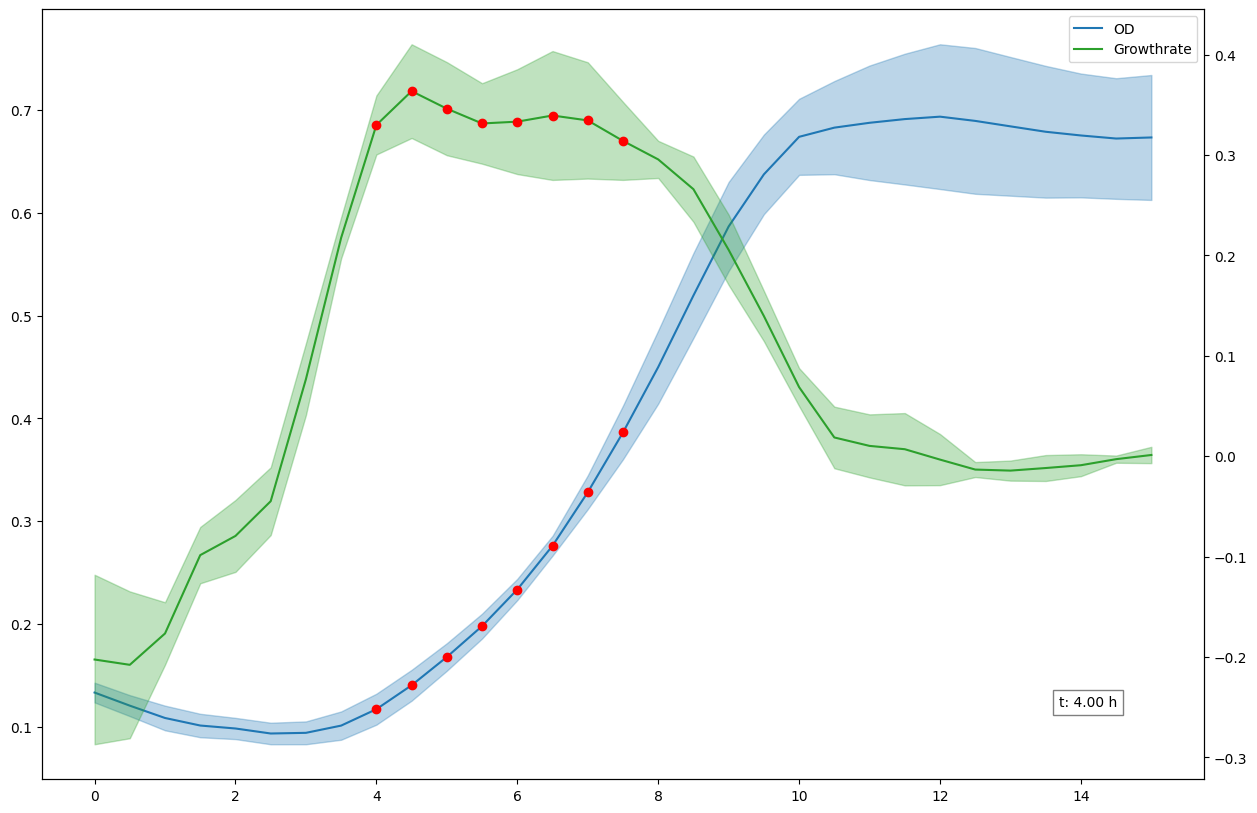

In [23]:
#@title Exponential phase window computation

#create new dataframes for each dataset: mean and std for each timepoint
DF_means = {}
DF_stds = {}

#iterating through datasets
for dataframe in DF_def:
    dataframe_self = DF_def[dataframe]
    df_means = pd.DataFrame()
    df_stds = pd.DataFrame()

    #iterating through samples
    for sample in samples_def:
        wells = samples_def[sample]
        df_means = pd.concat([df_means, dataframe_self[wells].mean(axis=1)], axis=1)
        df_stds = pd.concat([df_stds, dataframe_self[wells].std(axis=1)], axis=1)
    df_means.columns = sample_names
    df_stds.columns = sample_names
    DF_means.update({dataframe : df_means})
    DF_stds.update({dataframe : df_stds})

#create mean of growth of the whole plate
m = DF_means['OD'].mean(axis=1)
std = DF_means['OD'].std(axis=1)

gr_m = DF_means['Growth rate'].mean(axis=1)
gr_std = DF_means['Growth rate'].std(axis=1)

fig, ax = plt.subplots(figsize=(15,10))
l1 = ax.plot(time, m, color='tab:blue', label='OD')
ax.fill_between(time, m+std, m-std, alpha=0.3, color='tab:blue')
ax1 = ax.twinx()
l2 = ax1.plot(time, gr_m, color='tab:green', label='Growthrate')
ax1.fill_between(time, gr_m+gr_std, gr_m-gr_std, alpha=0.3, color='tab:green')

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

algorithm_tpoints_sample = {}
algorithm_wpoints_sample = {}
algorithm_dt_sample = {}
for sample in DF_means['OD']:
    data = m
    alg = algorithm_iteration(data, 1, bouts=bouts, doub_time=2, c=3, sn=('%s - %s' %(sample[0], well)))
    time_pts = alg[2]
    w_idcs = alg[1]
    dt = alg[8]
    algorithm_tpoints_sample.update({sample : time_pts})
    algorithm_wpoints_sample.update({sample : w_idcs})
    algorithm_dt_sample.update({sample : dt})

alg = algorithm_iteration(m, 1, bouts=bouts, doub_time=2, c=3, sn=('%s - %s' %(sample[0], well)))
ax.plot(alg[2], m[alg[2]], 'ro')
ax1.plot(alg[2], gr_m[alg[2]], 'ro')
ax1.text(0.9, 0.1,('t: %3.2f h' %alg[8]), transform=ax1.transAxes,
                 bbox=dict(facecolor='w', alpha=0.5), va='center', ha='center')
plt.show()

RadioButtons(description='Dataset: ', index=3, options=('RFP', 'OD', 'Growth rate', 'Dynamic Activity RFP'), v…

Button(description='Plot dataset', style=ButtonStyle())

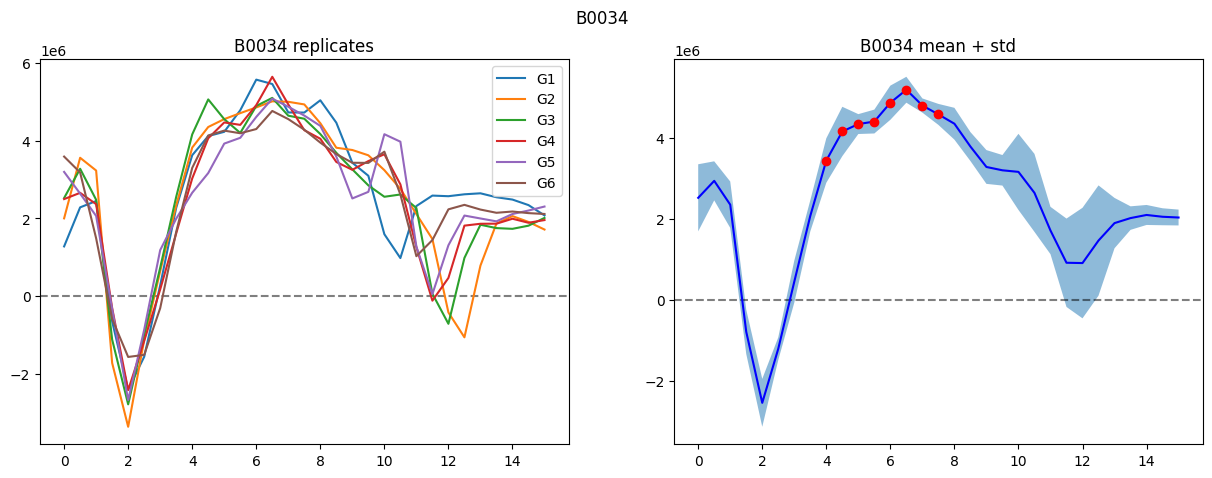

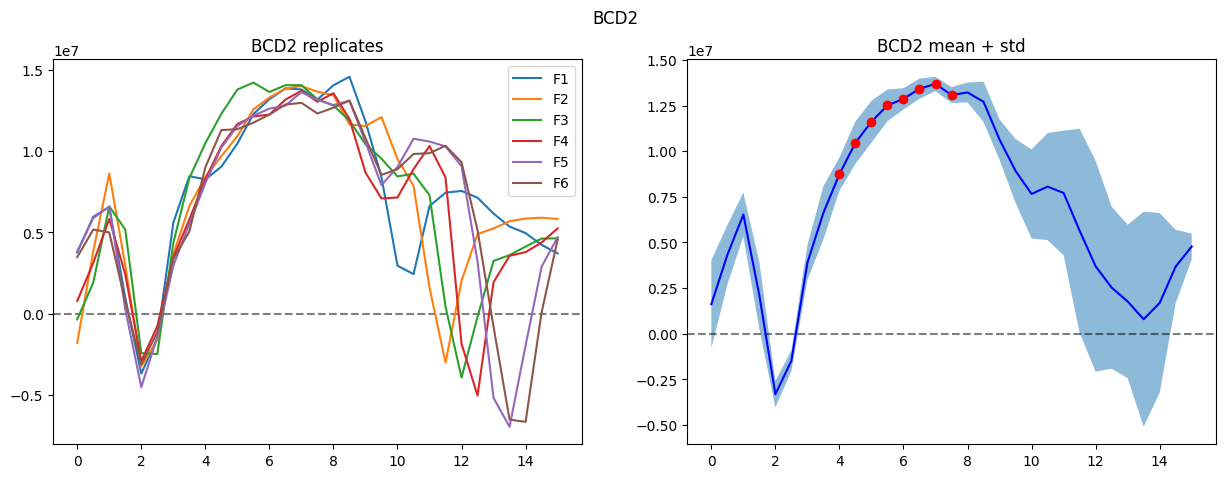

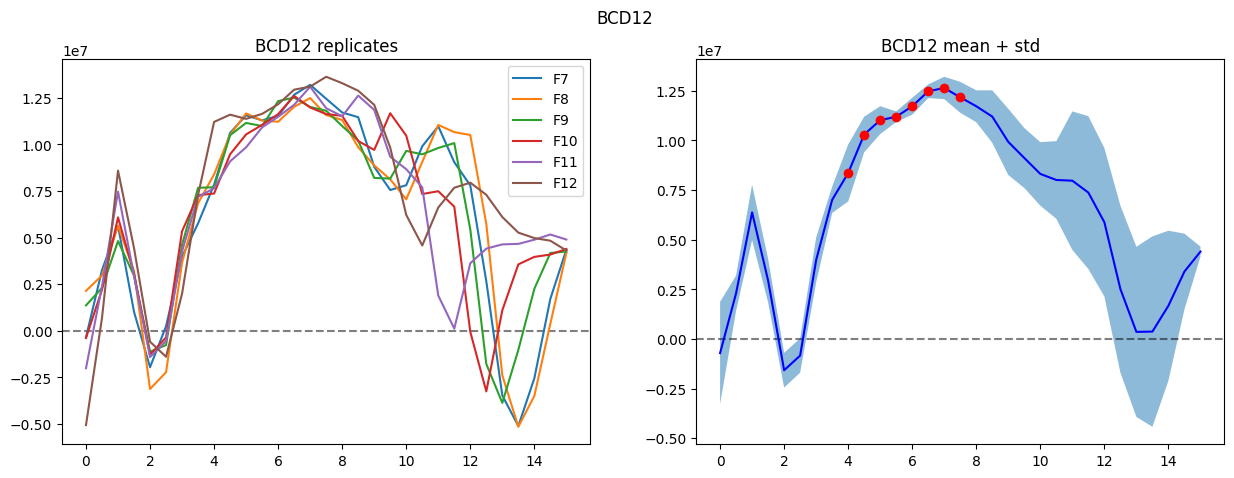

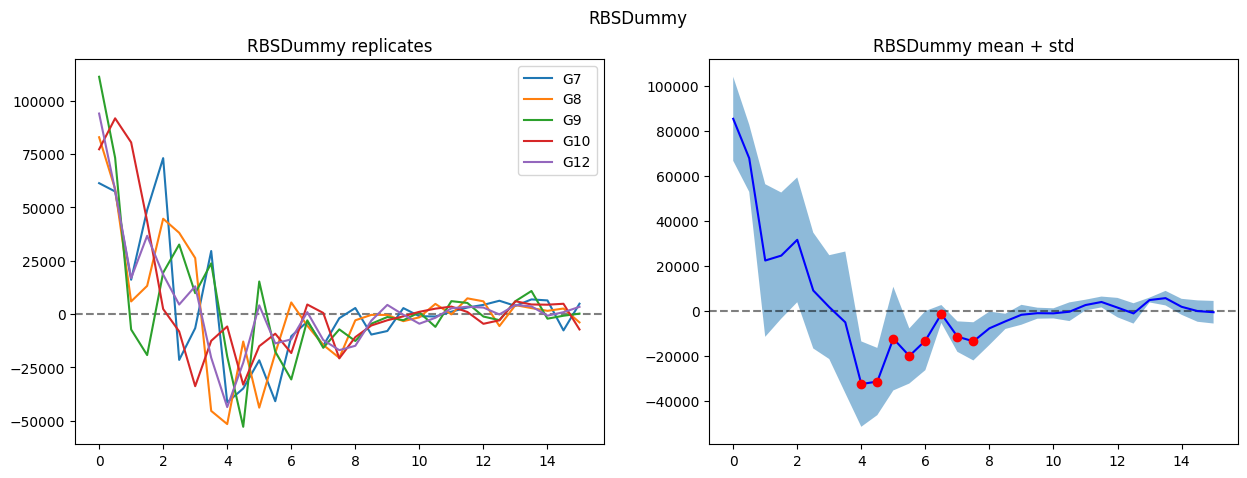

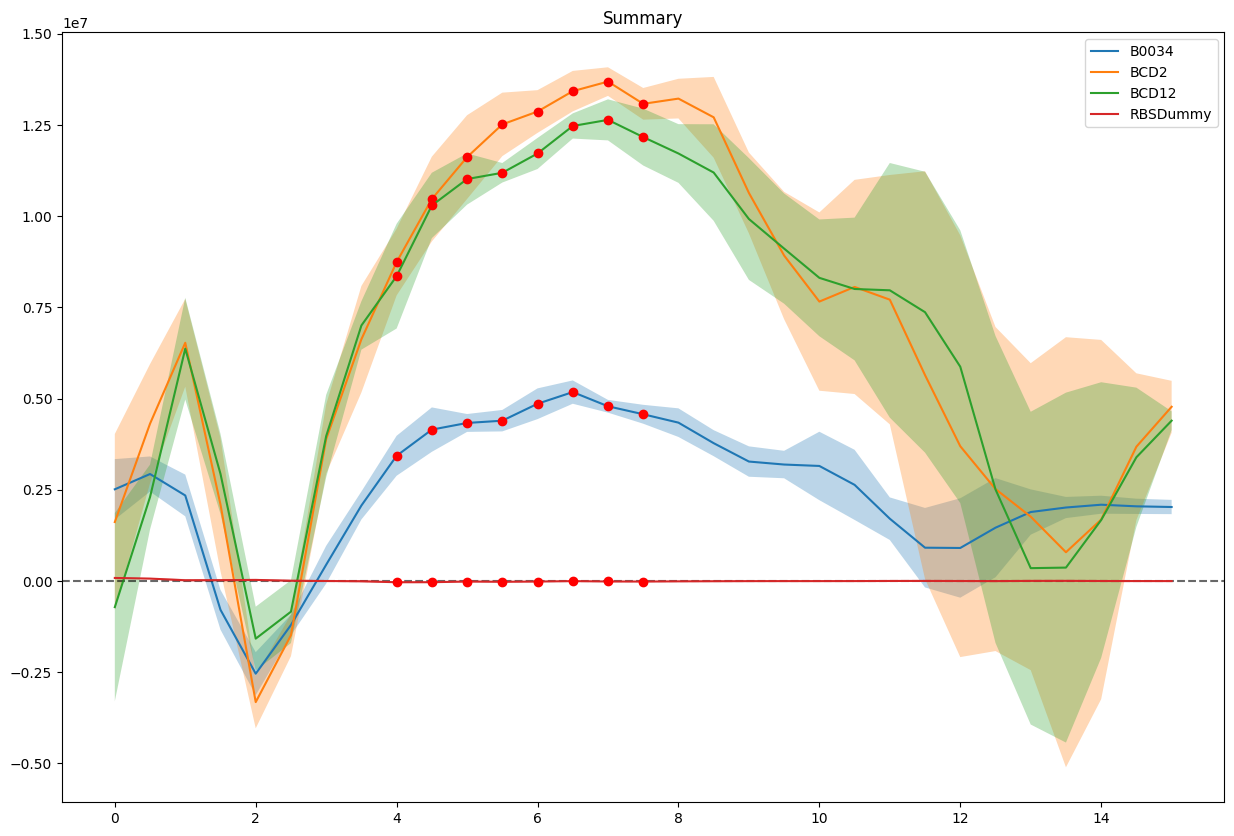

In [24]:
#@title Data visualization

#plot function
def plot_dataset(dataset):
  for sample in samples_def:
      wells = samples_def[sample]
      dataset_raw = DF_def[dataset]
      dataset_means = DF_means[dataset]
      dataset_stds = DF_stds[dataset]

      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
      fig.suptitle(sample)
      ax2.axhline(y=0, c='black', ls='--', alpha=0.5)
      ax2.plot(time, dataset_means[sample], 'b-')
      ax2.fill_between(time, dataset_means[sample]+dataset_stds[sample], dataset_means[sample]-dataset_stds[sample], alpha=0.5)
      ax2.set_title((sample + ' mean + std'))

      alg_time = algorithm_tpoints_sample[sample]
      ax2.plot(alg_time, dataset_means[sample][alg_time], 'ro')

      ax1.axhline(y=0, c='black', ls='--', alpha=0.5)
      for i in range(len(wells)):
          ax1.plot(time, dataset_raw[wells[i]], label=wells[i])
      ax1.set_title((sample + ' replicates'))

      ax1.legend()
      plt.show()

  fig, ax = plt.subplots(figsize=(15,10))
  for sample in samples_def:
      alg_time = algorithm_tpoints_sample[sample]
      ax.axhline(y=0, c='black', ls='--', alpha=0.2)
      ax.plot(time, DF_means[dataset][sample], label=sample)
      ax.plot(alg_time, DF_means[dataset][sample][alg_time], 'ro')
      ax.fill_between(time, dataset_means[sample]+dataset_stds[sample], dataset_means[sample]-dataset_stds[sample], alpha=0.3)
      ax.legend()
      ax.set_title('Summary')
  plt.show()
#dropdown menu to select sample to be plotted
selector = widgets.RadioButtons(
    options=[name for name in DF_def],
    description='Dataset: ',
    disabled=False)
display(selector)

plot_button = widgets.Button(description='Plot dataset')
clicked = False
def click_plot_button(b):
  clear_output(wait=True)
  display(selector)
  display(plot_button)
  plot_dataset(selector.value)

plot_button.on_click(click_plot_button)
display(plot_button)

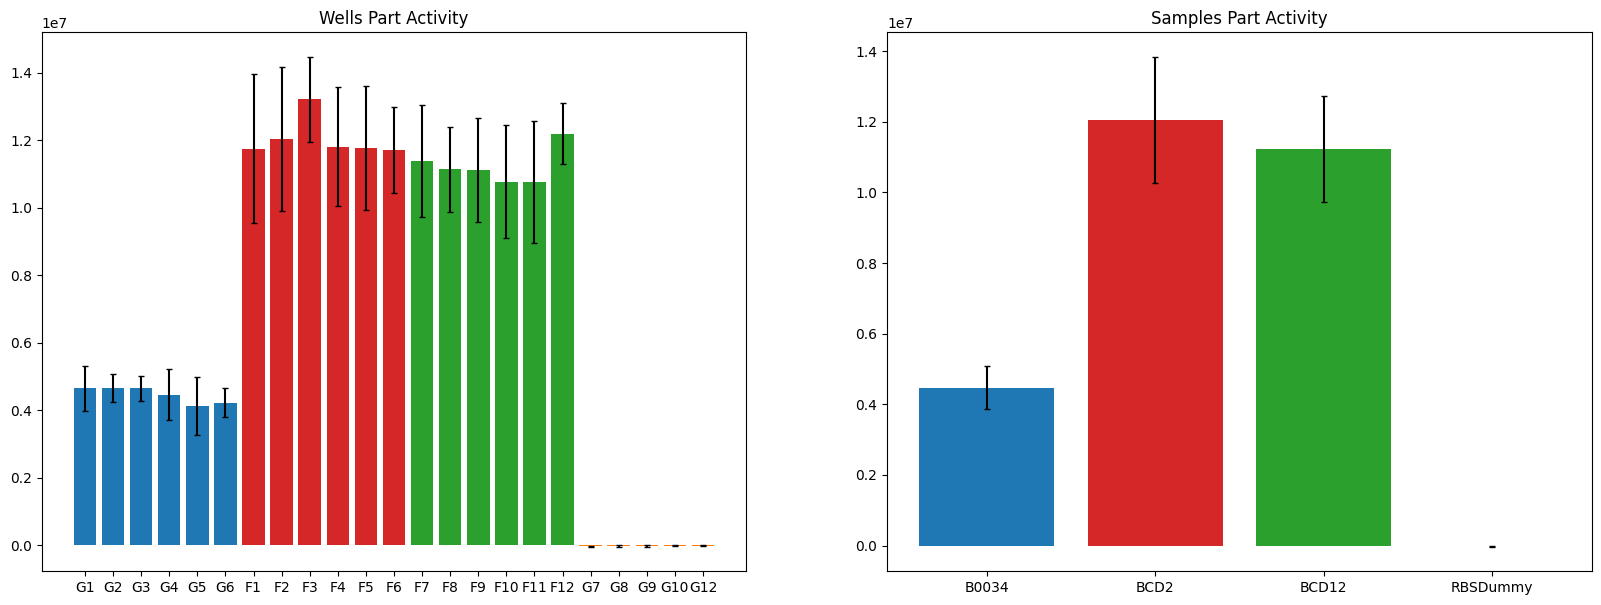

In [25]:
#@title Part Activity RFP computation

try:
  DF_def['GFP']
  gfp = True
except:
  gfp = False

tpoints = list(algorithm_tpoints_sample.values())[0]
a, b = tpoints[0], tpoints[-1]
PA_summary = {}
for sample in samples_def:
  for well in samples_def[sample]:
    data = DF_def['Dynamic Activity RFP'][well][a:b]
    PA_mean = data.mean(axis=0)
    PA_std = data.std(axis=0)
    PA_summary.update({well : (PA_mean, PA_std)})

res_samples = []
res_wells = []
res_means = []
res_stds = []

for sample in samples_def:
  for well in samples_def[sample]:
    res_samples.append(sample)
    res_wells.append(well)
    res_means.append(PA_summary[well][0])
    res_stds.append(PA_summary[well][1])

result = pd.DataFrame()
result['Well'] = res_wells
result['Sample'] = res_samples
result['Mean PA'] = res_means
result['STD'] = res_stds
result = result.set_index('Well')

x = -1
check = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.set_title('Wells Part Activity')
ax2.set_title('Samples Part Activity')
for well in result.index:
  c = result['Sample'][well]
  if c in check:
    x = x
    pass
  else:
    x += 1
    check.append(c)
  m = result['Mean PA'][well]
  std = result['STD'][well]
  ax1.bar(well, m, yerr=std, capsize=2, color=colors[x])

for c, sample in enumerate(samples_def):
  data = result.loc[result['Sample'] == sample]
  mean = data['Mean PA'].mean()
  std = np.sqrt(np.mean(data['STD']**2))
  ax2.bar(sample, mean, yerr=std, capsize=2, color=colors[c])
plt.show()

In [26]:
#@title Analysis RFP export

display(result)
print('')

csv_box = widgets.Checkbox(
    value=False,
    description='.csv',
    disabled=False,
    indent=False)
xlsx_box = widgets.Checkbox(
    value=False,
    description='.xslx',
    disabled=False,
    indent=False)

download_button = widgets.Button(description='Download')

def click_download_button(b):
  #clear_output(wait=True)
  #display(button)
  if fname.value == '':
    print('Enter a name for the output file')
  else:
    if csv_box.value == True and xlsx_box.value == True:
      export_name = create_file(fname=fname.value, format='.csv')
      temp = result.to_csv(export_name)
      FILES.download(export_name)
      print('\n Downloading .csv file')
      export_name = create_file(fname=fname.value, format='.xlsx')
      temp = result.to_excel(export_name)
      FILES.download(export_name)
      print('\n Downloading .xslx file')
    elif csv_box.value == True:
      export_name = create_file(fname=fname.value, format='.csv')
      temp = result.to_csv(export_name)
      FILES.download(export_name)
      print('\n Downloading .csv file')
    elif xlsx_box.value == True:
      export_name = create_file(fname=fname.value, format='.xlsx')
      temp = result.to_excel(export_name)
      FILES.download(export_name)
      print('\n Downloading .xslx file')

    else:
      print('Select a format to export')

download_button.on_click(click_download_button)

style = {'description_width': 'initial'}
fname = widgets.Text(
    placeholder='e.g. my_data_result',
    description='Enter output name:',
    style=style,
    disabled=False)

items = [fname, csv_box, xlsx_box, download_button]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns='350px 70px 100px 350px'))
display(grid)

,Sample,Mean PA,STD
Well,,,
G1,B0034,4.656558e+06,6.595767e+05
G2,B0034,4.657278e+06,4.077777e+05
G3,B0034,4.649539e+06,3.569070e+05
G4,B0034,4.468264e+06,7.641774e+05
G5,B0034,4.131493e+06,8.532123e+05
G6,B0034,4.225170e+06,4.271904e+05
F1,BCD2,1.175468e+07,2.208058e+06
F2,BCD2,1.204447e+07,2.123163e+06
F3,BCD2,1.321150e+07,1.264406e+06


GridBox(children=(Text(value='', description='Enter output name:', placeholder='e.g. my_data_result', style=De…

In [27]:
#@title Part Activity GFP computation

if gfp == False:
  print('No GFP measured in this experiment')
else:
  tpoints = list(algorithm_tpoints_sample.values())[0]
  a, b = tpoints[0], tpoints[-1]
  PA_summary_gfp = {}
  for sample in samples_def:
    for well in samples_def[sample]:
      data = DF_def['Dynamic Activity GFP'][well][a:b]
      PA_mean = data.mean(axis=0)
      PA_std = data.std(axis=0)
      PA_summary_gfp.update({well : (PA_mean, PA_std)})

  res_samples = []
  res_wells = []
  res_means = []
  res_stds = []

  for sample in samples_def:
    for well in samples_def[sample]:
      res_samples.append(sample)
      res_wells.append(well)
      res_means.append(PA_summary_gfp[well][0])
      res_stds.append(PA_summary_gfp[well][1])

  result_gfp = pd.DataFrame()
  result_gfp['Well'] = res_wells
  result_gfp['Sample'] = res_samples
  result_gfp['Mean PA'] = res_means
  result_gfp['STD'] = res_stds
  result_gfp = result_gfp.set_index('Well')

  x = -1
  check = []

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
  ax1.set_title('Wells Part Activity')
  ax2.set_title('Samples Part Activity')
  for well in result_gfp.index:
    c = result_gfp['Sample'][well]
    if c in check:
      x = x
      pass
    else:
      x += 1
      check.append(c)
    m = result_gfp['Mean PA'][well]
    std = result_gfp['STD'][well]
    ax1.bar(well, m, yerr=std, capsize=2, color=colors[x])

  for c, sample in enumerate(samples_def):
    data = result_gfp.loc[result_gfp['Sample'] == sample]
    mean = data['Mean PA'].mean()
    std = np.sqrt(np.mean(data['STD']**2))
    ax2.bar(sample, mean, yerr=std, capsize=2, color=colors[c])
  plt.show()

No GFP measured in this experiment


In [28]:
#@title Analysis GFP export

if gfp == False:
  print('No GFP measured in this experiment')
else:
  display(result_gfp)
  print('')

  csv_box_ = widgets.Checkbox(
      value=False,
      description='.csv',
      disabled=False,
      indent=False)
  xlsx_box_ = widgets.Checkbox(
      value=False,
      description='.xslx',
      disabled=False,
      indent=False)

  download_button_ = widgets.Button(description='Download')

  def click_download_button_(b):
    #clear_output(wait=True)
    #display(button)
    if fname_.value == '':
      print('Enter a name for the output file')
    else:
      if csv_box_.value == True and xlsx_box_.value == True:
        export_name = create_file(fname=fname_.value, format='.csv')
        temp = result_gfp.to_csv(export_name)
        FILES.download(export_name)
        print('\n Downloading .csv file')
        export_name = create_file(fname=fname_.value, format='.xlsx')
        temp = result_gfp.to_excel(export_name)
        FILES.download(export_name)
        print('\n Downloading .xslx file')
      elif csv_box_.value == True:
        export_name = create_file(fname=fname_.value, format='.csv')
        temp = result_gfp.to_csv(export_name)
        FILES.download(export_name)
        print('\n Downloading .csv file')
      elif xlsx_box_.value == True:
        export_name = create_file(fname=fname_.value, format='.xlsx')
        temp = result_gfp.to_excel(export_name)
        FILES.download(export_name)
        print('\n Downloading .xslx file')

      else:
        print('Select a format to export')

  download_button_.on_click(click_download_button)

  style = {'description_width': 'initial'}
  fname_ = widgets.Text(
      placeholder='e.g. my_data_result',
      description='Enter output name:',
      style=style,
      disabled=False)

  items_ = [fname_, csv_box_, xlsx_box_, download_button_]
  grid_ = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns='350px 70px 100px 350px'))
  display(grid_)

No GFP measured in this experiment
